In [ ]:
# load data
import pickle
import pandas as pd
from tensorflow.data import Dataset
from DGMM_utils import getlabels, alphabet, symbol_to_idx

train_size = 10000
test_size = 1000
batch_size = 16
pad_to_len = 80
MAXLEN=80

def get_ds(df):
    df1 = df.sample(frac=1)
    train_data = df1.iloc[:int(len(df)*0.8),:]
    test_data = df1.iloc[int(len(df)*0.8):,:]
    
    if len(train_data) > train_size:
        train_data = train_data.sample(n=train_size)
    if len(test_data) > test_size:
        test_data = test_data.sample(n=test_size)
        
    symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
    inp_train = getlabels(train_data['sfi'].values, pad_to_len)
    train_ds = Dataset.from_tensor_slices((inp_train))
    train_ds = train_ds.batch(batch_size)

    inp_test = getlabels(test_data['sfi'].values, pad_to_len)
    test_ds = Dataset.from_tensor_slices((inp_test))
    test_ds = test_ds.batch(batch_size)
    print(f'load train set: {len(train_data)} mols, test set {len(test_data)} mols.')

    return train_ds, test_ds

In [ ]:
# df = pd.read_hdf('data/zinc_train_ext.h5')
df = pd.read_hdf('data/zinc_train.h5')
train_ds, test_ds = get_ds(df.sample(n=1000))

# D-encoder Training

In [ ]:
# Dencoder
import numpy as np
import tensorflow as tf
import selfies as sf
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
from DGMM_utils import DVAEencoder

class lrScheduler(keras.callbacks.Callback):
    def __init__(self, ep=2, verbose=0):
        super(lrScheduler, self).__init__()
        self.verbose = verbose
        self.ep = ep

    def on_epoch_begin(self, epoch, logs=None):
        lr = float(keras.backend.get_value(self.model.optimizer.lr))
        if epoch > self.ep:
            lr = lr * tf.math.exp(-0.1)
            keras.backend.set_value(self.model.optimizer.lr, keras.backend.get_value(lr))
            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = keras.backend.get_value(self.model.optimizer.lr)

####################
#set the path to your model path#
####################
model_path = '/opt/jupyter/DGMM/model/'
####################

model = DVAEencoder(model_path, gene_range=8, gene_length=320, latent_dim=8)
model.compile()
checkpoint = keras.callbacks.ModelCheckpoint('test', monitor='latent_mae', verbose=1, save_best_only=True)
callbacks=[keras.callbacks.TerminateOnNaN(), lrScheduler(), checkpoint]

In [26]:
# from DGMM_utils import VectorQuantizer
# latent2vec = keras.models.load_model('model/DVAE/latent2vec.h5', custom_objects={'VectorQuantizer':VectorQuantizer})
# vec2latent = keras.models.load_model('model/DVAE/vec2latent.h5')
# model.latent2vec.set_weights(latent2vec.get_weights())
# model.vec2latent.set_weights(vec2latent.get_weights())

In [472]:
his = model.fit(train_ds, validation_data=test_ds, epochs=1, callbacks=callbacks)

49999/50000 [============================>.] - ETA: 0s - total_loss: 1.2488 - vqvae_loss: 0.4653 - perplexity: 7.7149 - latent_mae: 0.0130
Epoch 1: latent_mae improved from 0.01740 to 0.01024, saving model to vae_sfi
50000/50000 [==============================] - 2656s 53ms/step - total_loss: 1.2488 - vqvae_loss: 0.4653 - perplexity: 7.7149 - latent_mae: 0.0130 - val_accuracy: 0.8968


In [475]:
his = model.fit(train_ds, validation_data=test_ds, epochs=1, callbacks=callbacks)

50000/50000 [==============================] - ETA: 0s - total_loss: 0.3902 - vqvae_loss: 0.0807 - perplexity: 7.1456 - latent_mae: 0.0044
Epoch 1: latent_mae improved from 0.01024 to 0.00398, saving model to vae_sfi
50000/50000 [==============================] - 2698s 54ms/step - total_loss: 0.3902 - vqvae_loss: 0.0807 - perplexity: 7.1456 - latent_mae: 0.0044 - val_accuracy: 0.9029


In [663]:
his = model.fit(train_ds1, validation_data=test_ds1, epochs=10, callbacks=callbacks)

Epoch 1/10
500/500 [==============================] - ETA: 0s - total_loss: 0.3405 - vqvae_loss: 0.0614 - perplexity: 7.1880 - latent_mae: 0.0035 - student_acc: 0.9043
Epoch 1: student_acc improved from 0.90447 to 0.90515, saving model to vae_sfi
500/500 [==============================] - 65s 128ms/step - total_loss: 0.3405 - vqvae_loss: 0.0614 - perplexity: 7.1880 - latent_mae: 0.0035 - student_acc: 0.9043 - val_accuracy: 0.9078
Epoch 2/10
500/500 [==============================] - ETA: 0s - total_loss: 0.3385 - vqvae_loss: 0.0603 - perplexity: 7.1914 - latent_mae: 0.0035 - student_acc: 0.9038
Epoch 2: student_acc did not improve from 0.90515
500/500 [==============================] - 62s 124ms/step - total_loss: 0.3385 - vqvae_loss: 0.0603 - perplexity: 7.1914 - latent_mae: 0.0035 - student_acc: 0.9038 - val_accuracy: 0.9100
Epoch 3/10
500/500 [==============================] - ETA: 0s - total_loss: 0.3428 - vqvae_loss: 0.0616 - perplexity: 7.2093 - latent_mae: 0.0036 - student_acc: 

In [3]:
from DGMM_utils import smiles2inp

smi = 'S=C1Sc2cc(Br)ccc2C2=NCCCN12'
test_inp = smiles2inp(smi)
gene_mean, gene_var, gene = model.critic_encoder(test_inp)
quantized_latents, perplexity = model.latent2vec(gene)
encoding_indices = model.vq_layer.get_code_indices(quantized_latents).numpy()

In [4]:
encoding_indices

array([2, 3, 0, 2, 3, 3, 4, 5, 2, 7, 6, 5, 5, 6, 0, 7, 3, 4, 2, 7, 4, 6,
       2, 7, 5, 4, 6, 3, 2, 3, 2, 0, 5, 7, 5, 5, 0, 3, 4, 0, 7, 7, 2, 2,
       3, 4, 3, 5, 5, 2, 7, 5, 6, 3, 6, 3, 7, 3, 2, 5, 2, 7, 2, 0, 0, 2,
       2, 3, 5, 5, 3, 7, 3, 7, 5, 0, 0, 3, 2, 0, 4, 5, 3, 7, 4, 5, 2, 5,
       3, 2, 7, 2, 4, 2, 3, 7, 2, 7, 2, 6, 7, 5, 3, 7, 7, 1, 2, 4, 7, 2,
       3, 6, 2, 7, 5, 4, 2, 7, 7, 0, 7, 7, 4, 5, 3, 4, 6, 5, 3, 4, 2, 5,
       3, 2, 4, 2, 3, 3, 7, 7, 7, 5, 3, 0, 7, 7, 2, 6, 7, 0, 7, 3, 5, 7,
       5, 3, 0, 3, 2, 0, 7, 2, 3, 5, 2, 3, 3, 5, 7, 2, 6, 5, 3, 3, 3, 3,
       2, 2, 7, 7, 7, 4, 2, 7, 2, 2, 6, 3, 7, 3, 7, 3, 5, 7, 5, 2, 2, 3,
       7, 0, 2, 2, 4, 5, 3, 3, 4, 5, 7, 4, 7, 7, 2, 7, 3, 2, 3, 2, 3, 2,
       5, 5, 2, 2, 3, 2, 7, 7, 7, 6, 2, 2, 5, 7, 7, 7, 2, 7, 7, 2, 7, 5,
       2, 4, 3, 6, 2, 0, 5, 3, 7, 7, 2, 7, 4, 6, 3, 6, 7, 7, 4, 5, 7, 2,
       4, 3, 0, 0, 7, 3, 2, 7, 2, 7, 2, 0, 2, 2, 4, 4, 7, 5, 2, 2, 3, 4,
       2, 5, 2, 7, 7, 5, 6, 3, 1, 2, 2, 2, 4, 7, 3,

# D-Decoder training

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from DGMM_utils import DVAEdecoder
    
class lrScheduler(keras.callbacks.Callback):
    def __init__(self, ep=2, verbose=0):
        super(lrScheduler, self).__init__()
        self.verbose = verbose
        self.ep = ep

    def on_epoch_begin(self, epoch, logs=None):
        lr = float(keras.backend.get_value(self.model.optimizer.lr))
        if epoch > self.ep:
            lr = lr * tf.math.exp(-0.1)
            keras.backend.set_value(self.model.optimizer.lr, keras.backend.get_value(lr))
            
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = keras.backend.get_value(self.model.optimizer.lr)
####################
#set the path to your model path#
####################
model_path = '/opt/jupyter/molmod/DGMM_github/DGMM/model/'
####################

model = DVAEdecoder(model_path, gene_range=8, gene_length=320, latent_dim=8,T=3., alpha=0.1)
model.compile()
checkpoint = keras.callbacks.ModelCheckpoint('test', monitor='student_acc', verbose=1, save_best_only=True)
callbacks=[keras.callbacks.TerminateOnNaN(), lrScheduler(), checkpoint]

In [549]:
model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=callbacks)

Epoch 1/10
5000/5000 [==============================] - ETA: 0s - total_loss: 0.9041 - perplexity: 7.0122 - latent_mae: 10.9226 - student_acc: 0.6744
Epoch 1: student_acc improved from -inf to 0.73256, saving model to vae_sfi
5000/5000 [==============================] - 608s 119ms/step - total_loss: 0.9041 - perplexity: 7.0122 - latent_mae: 10.9240 - student_acc: 0.6744 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 2/10
5000/5000 [==============================] - ETA: 0s - total_loss: 0.5224 - perplexity: 7.0094 - latent_mae: 48.1677 - student_acc: 0.8262
Epoch 2: student_acc improved from 0.73256 to 0.83472, saving model to vae_sfi
5000/5000 [==============================] - 645s 129ms/step - total_loss: 0.5224 - perplexity: 7.0094 - latent_mae: 48.1698 - student_acc: 0.8262 - val_accuracy: 0.8481 - lr: 0.0010
Epoch 3/10
5000/5000 [==============================] - ETA: 0s - total_loss: 0.4538 - perplexity: 7.0025 - latent_mae: 89.7350 - student_acc: 0.8514
Epoch 3: student_acc improved

In [ ]:
model.fit(train_ds, validation_data=test_ds, epochs=6, callbacks=callbacks)

Epoch 1/6
50000/50000 [==============================] - ETA: 0s - total_loss: 0.1872 - perplexity: 7.0159 - latent_mae: 176.6737 - student_acc: 0.9324
Epoch 1: student_acc improved from 0.89848 to 0.93602, saving model to vae_sfi
50000/50000 [==============================] - 5748s 115ms/step - total_loss: 0.1872 - perplexity: 7.0159 - latent_mae: 176.6737 - student_acc: 0.9324 - val_accuracy: 0.9410 - lr: 4.9659e-04
Epoch 2/6
50000/50000 [==============================] - ETA: 0s - total_loss: 0.1682 - perplexity: 7.0142 - latent_mae: 168.9496 - student_acc: 0.9414
Epoch 2: student_acc improved from 0.93602 to 0.94227, saving model to vae_sfi
50000/50000 [==============================] - 5744s 115ms/step - total_loss: 0.1682 - perplexity: 7.0142 - latent_mae: 168.9495 - student_acc: 0.9414 - val_accuracy: 0.9434 - lr: 4.9659e-04
Epoch 3/6
 7554/50000 [===>..........................] - ETA: 1:16:55 - total_loss: 0.1632 - perplexity: 7.0139 - latent_mae: 162.0544 - student_acc: 0.9439

In [555]:
model.fit(train_ds, validation_data=test_ds, epochs=3, callbacks=callbacks)

Epoch 1/3
50000/50000 [==============================] - ETA: 0s - total_loss: 0.1585 - perplexity: 7.0136 - latent_mae: 157.2946 - student_acc: 0.9452
Epoch 1: student_acc improved from 0.94227 to 0.94554, saving model to vae_sfi
50000/50000 [==============================] - 5722s 114ms/step - total_loss: 0.1585 - perplexity: 7.0136 - latent_mae: 157.2946 - student_acc: 0.9452 - val_accuracy: 0.9462 - lr: 4.9659e-04
Epoch 2/3
50000/50000 [==============================] - ETA: 0s - total_loss: 0.1539 - perplexity: 7.0154 - latent_mae: 150.5046 - student_acc: 0.9468
Epoch 2: student_acc improved from 0.94554 to 0.94713, saving model to vae_sfi
50000/50000 [==============================] - 5738s 115ms/step - total_loss: 0.1539 - perplexity: 7.0154 - latent_mae: 150.5045 - student_acc: 0.9468 - val_accuracy: 0.9478 - lr: 4.9659e-04
Epoch 3/3
50000/50000 [==============================] - ETA: 0s - total_loss: 0.1505 - perplexity: 7.0145 - latent_mae: 144.9973 - student_acc: 0.9480
Epoc

In [556]:
model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=callbacks)

Epoch 1/10
50000/50000 [==============================] - ETA: 0s - total_loss: 0.1481 - perplexity: 7.0165 - latent_mae: 142.8338 - student_acc: 0.9490
Epoch 1: student_acc improved from 0.94830 to 0.94916, saving model to vae_sfi
50000/50000 [==============================] - 5897s 118ms/step - total_loss: 0.1481 - perplexity: 7.0165 - latent_mae: 142.8338 - student_acc: 0.9490 - val_accuracy: 0.9491 - lr: 4.9659e-04
Epoch 2/10
50000/50000 [==============================] - ETA: 0s - total_loss: 0.1462 - perplexity: 7.0150 - latent_mae: 141.7281 - student_acc: 0.9497
Epoch 2: student_acc improved from 0.94916 to 0.94982, saving model to vae_sfi
50000/50000 [==============================] - 5566s 111ms/step - total_loss: 0.1462 - perplexity: 7.0150 - latent_mae: 141.7281 - student_acc: 0.9497 - val_accuracy: 0.9496 - lr: 4.9659e-04
Epoch 3/10
50000/50000 [==============================] - ETA: 0s - total_loss: 0.1445 - perplexity: 7.0154 - latent_mae: 137.6690 - student_acc: 0.9504
E

# Mutation Comparison

In [7]:
from DGMM_utils import smiles2inp
rock2_cluster_df = pd.read_csv('data/rock2_cluster.csv')
flag = []
for s in rock2_cluster_df['smiles']:
    try:
        smiles2inp(s)
        flag.append(True)
    except:
        flag.append(False)
        print(s, ' invalid')
rock2_cluster_df = rock2_cluster_df[flag]
test1 = smiles2inp(rock2_cluster_df['smiles'])
gene_mean, gene_var, raw_gene = model.critic_encoder.predict(test1, verbose=0)

[C-]#[N+]c1cc(N2CCC(Nc3cc(F)cc(OC)c3)C2=O)ccc1-c1cn[nH]c1  invalid


In [17]:
# Umap reducer training
import umap
test1 = smiles2inp(df['smiles'])
gene_mean, gene_var, gene = model.critic_encoder.predict(test1, verbose=1)
a_UMAP_gene_reducer = umap.UMAP(n_neighbors=10, min_dist=0.8).fit(gene)

3125/3125 [==============================] - 88s 28ms/step


<AxesSubplot:xlabel='x1', ylabel='x2'>

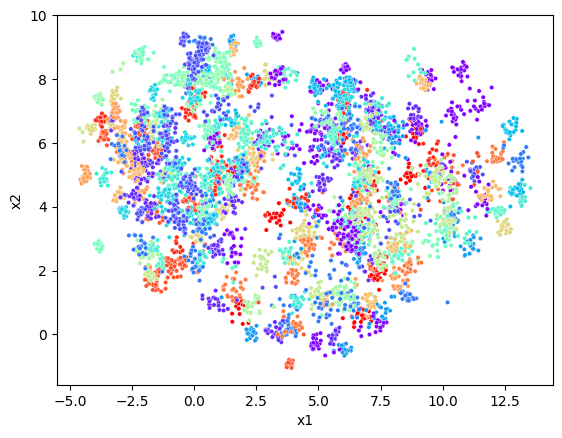

In [19]:
# Continuous Mutation
mux = []
muy = []
cluster = []
noise_norm=5.
mu_num = 20
n_gene = []
for idx in range(len(raw_gene)):
    for i in range(mu_num):
        _gene = raw_gene[idx]
        noise_vec = np.random.normal(0, 1, size=_gene.shape)
        noise_vec = noise_vec / np.linalg.norm(noise_vec)
        noise_amp = np.random.uniform(0, noise_norm, size=(1, tf.shape(_gene)[0]))
        _gene += (noise_amp * noise_vec)[0]
        n_gene.append(_gene)
        
anchor = a_UMAP_gene_reducer.transform(n_gene)

draw_df = pd.DataFrame({
    'x1': anchor[:,0],
    'x2': anchor[:,1],
    'cluster': np.repeat(rock2_cluster_df['cluster'].tolist(),mu_num)
})

import seaborn as sns
sns.scatterplot(
    data=draw_df, x="x1", y="x2", hue="cluster", palette='rainbow', legend=False, s=10
)

<AxesSubplot:xlabel='x1', ylabel='x2'>

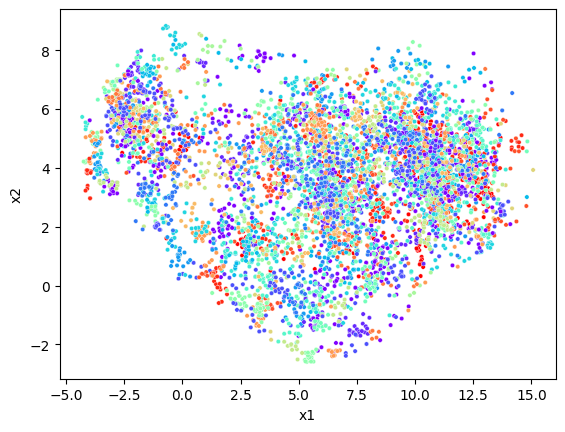

In [543]:
# Discrete Mutation
from tqdm import tqdm

codebook = model.latent2vec.layers[-1].embeddings.numpy()
vec2latent = keras.models.load_model('model/DVAE/vec2latent.h5')

vfactor = 0.1
mu_num = 20
n_gene = []
for idx in tqdm(range(len(raw_gene))):
    _gene = raw_gene[idx]
    qlatent = model.latent2vec.predict(_gene.reshape([-1,80]), verbose = 0)[0]
    mol_gene = model.latent2vec.layers[-1].get_code_indices(qlatent).numpy()
    npoint = int(80*vfactor)
    latents = []
    for i in range(mu_num):
        mol_gene1 = mol_gene
        pos = np.random.choice(np.arange(80),np.random.randint(0, npoint), replace=False)
        mol_gene1[pos] = np.random.choice(np.arange(8), len(pos))
        latent = np.matmul(np.eye(8)[mol_gene1], codebook.T).reshape([8, -1])
        latents.append(latent)
    n_gene += vec2latent.predict(np.array(latents), verbose=0).tolist()

anchor = a_UMAP_gene_reducer.transform(n_gene)    

draw_df = pd.DataFrame({
    'x1': anchor[:,0],
    'x2': anchor[:,1],
    'cluster': np.repeat(rock2_cluster_df['cluster'].tolist(),mu_num)
}) 

import seaborn as sns
sns.scatterplot(
    data=draw_df, x="x1", y="x2", hue="cluster", palette='rainbow', legend=False, s=10
)

# Scaffold Cluster in Mol-gene space

In [24]:
from DGMM_utils import smiles2inp
rock2_cluster_df = pd.read_csv('data/rock2_cluster.csv')
flag = []
for s in rock2_cluster_df['smiles']:
    try:
        smiles2inp(s)
        flag.append(True)
    except:
        flag.append(False)
        print(s, ' invalid')
rock2_cluster_df = rock2_cluster_df[flag]
test1 = smiles2inp(rock2_cluster_df['smiles'])
gene_mean, gene_var, gene = model.critic_encoder.predict(test1, verbose=0)

[C-]#[N+]c1cc(N2CCC(Nc3cc(F)cc(OC)c3)C2=O)ccc1-c1cn[nH]c1  invalid


<AxesSubplot:xlabel='x1', ylabel='x2'>

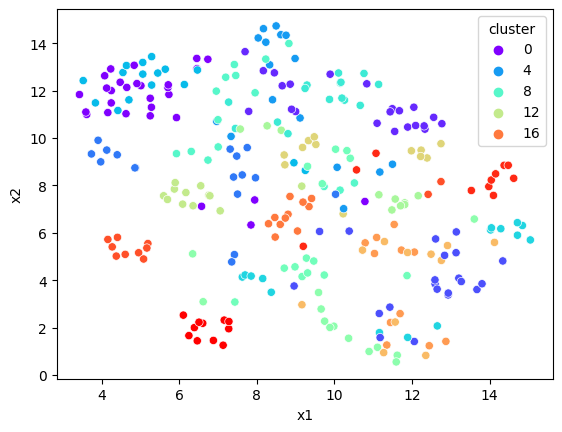

In [27]:
import umap
quantized_latents = model.latent2vec.predict(gene, verbose = 0)[0]
UMAP_gene_reducer = umap.UMAP(n_neighbors=10, min_dist=0.8).fit(quantized_latents.reshape(len(gene), -1))
embedding = UMAP_gene_reducer.transform(quantized_latents.reshape(len(gene), -1))
rock2_cluster_df['x1'] = embedding[:,0]
rock2_cluster_df['x2'] = embedding[:,1]
sns.scatterplot(
    data=rock2_cluster_df, x="x1", y="x2", hue="cluster", palette='rainbow'
)

# Similar SMILES in Mol-Gene Space

In [47]:
test_df = pd.read_csv('data/smiles_test.csv')
smis = test_df['smiles'].tolist()
flag = []
for s in smis:
    try:
        smiles2inp(s)
        flag.append(True)
    except:
        flag.append(False)
        print(s, ' invalid')
test_df = test_df[flag]

test1 = smiles2inp(test_df['smiles'])
gene_mean, gene_var, gene = model.critic_encoder.predict(test1, verbose=1)
quantized_latents,p = model.latent2vec.predict(gene, verbose = 0)

5/5 [==============================] - 0s 47ms/step


<AxesSubplot:xlabel='x1', ylabel='x2'>

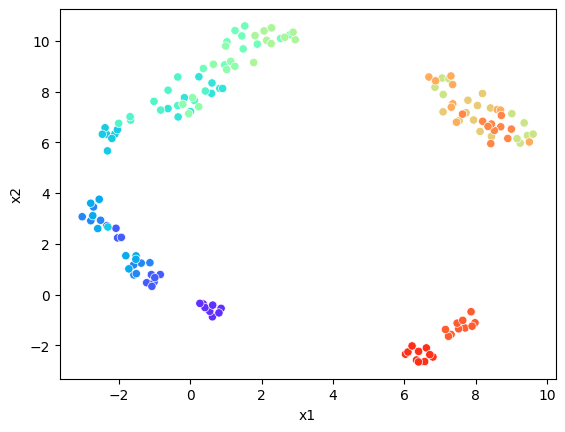

In [510]:
import seaborn as sns
import umap
UMAP_gene_reducer = umap.UMAP(n_neighbors=10, min_dist=0.3).fit(test1)
embedding = UMAP_gene_reducer.transform(test1)
test_df['x1'] = embedding[:,0]
test_df['x2'] = embedding[:,1]
sns.scatterplot(
    data=test_df, x="x1", y="x2", hue="source", palette='rainbow', legend=False
)

<AxesSubplot:xlabel='x1', ylabel='x2'>

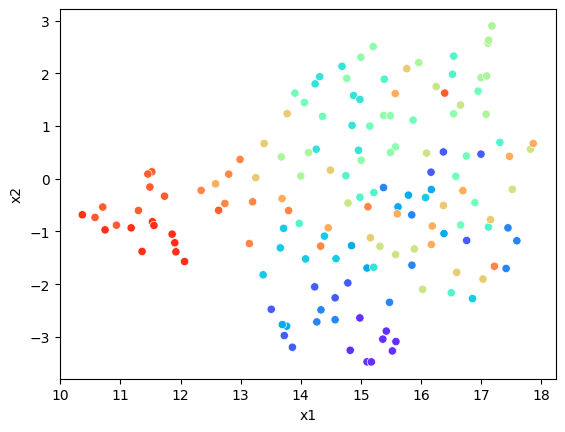

In [51]:
import seaborn as sns
import umap
# UMAP_gene_reducer = umap.UMAP(n_neighbors=10, min_dist=0.1).fit(indices)
# embedding = UMAP_gene_reducer.transform(indices)
UMAP_gene_reducer = umap.UMAP(n_neighbors=10, min_dist=0.3).fit(quantized_latents.reshape(len(gene), -1))
embedding = UMAP_gene_reducer.transform(quantized_latents.reshape(len(gene), -1))
test_df['x1'] = embedding[:,0]
test_df['x2'] = embedding[:,1]
sns.scatterplot(
    data=test_df, x="x1", y="x2", hue="source", palette='rainbow', legend=False
)

<AxesSubplot:xlabel='x1', ylabel='x2'>

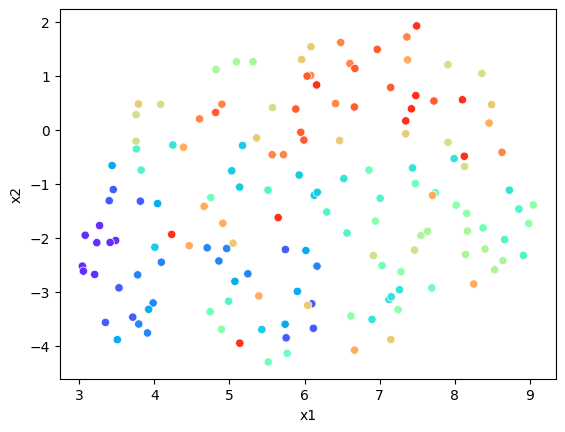

In [50]:
import seaborn as sns
import umap
UMAP_gene_reducer = umap.UMAP(n_neighbors=10, min_dist=0.3).fit(gene)
embedding = UMAP_gene_reducer.transform(gene)
test_df['x1'] = embedding[:,0]
test_df['x2'] = embedding[:,1]
sns.scatterplot(
    data=test_df, x="x1", y="x2", hue="source", palette='rainbow', legend=False
)